In [1]:

# standard library imports
import git, os, sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
os.chdir(f'{git_root}/src')
sys.path.append(os.path.abspath(os.path.join(f'{git_root}/src')))
print(f'Changed working directory to {os.getcwd()}')

# local imports
from fight_stat_helpers import *
from data_handler import DataHandler

Changed working directory to C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src


# NEW FEATURES

- Dominance Score for a single fight: (total score of fighter based on events in the fight) - (total score of opponent based on events in the fight)
- Average Dominance over time scales
- Fighter Scores
- Fight Math
- Fighter Score increments based on closeness of fights with opponents with high scores 

# Other things to try
- with or without regularization
- with or without scaling
- with or without sum features (seems like only age needs sum features)
- with or without squared features (seems like only age needs squared features)
- Decide whether to include SDEC in bullshit or not
- Do linear reg on draws and SDEC and see how this compares to log reg plane (hypothesis: they are the same plane since close fights should be near the plane boundary)

In [2]:
dh = DataHandler()
# get reported derived doubled data
ufc_fights_reported_derived_doubled = dh.get('ufc_fights_reported_derived_doubled')

In [3]:
# only take fights in the last 10 years
ufc_fights_reported_derived_doubled['date'] = pd.to_datetime(ufc_fights_reported_derived_doubled['date'])
date_10_years_ago = pd.Timestamp.now() - pd.DateOffset(years=10)
ufc_fights_reported_derived_doubled = ufc_fights_reported_derived_doubled[ufc_fights_reported_derived_doubled['date'] >= date_10_years_ago]
ufc_fights_reported_derived_doubled.shape

(9864, 326)

In [4]:
ufc_fights_reported_derived_doubled['age']

6670     28.024641
6671     31.854894
6672     27.460643
6673     22.680356
6674     27.915127
           ...    
16529    29.264887
16530    32.744695
16531    32.229979
16532    29.744011
16533    25.514031
Name: age, Length: 9864, dtype: float64

In [5]:
# add columns of the form dist_age_from_33
age_cols = []
for i in range(20,40):
    age_stat_name = f'dist_age_from_{i}'
    age_cols.append(age_stat_name)
    age_diff = ufc_fights_reported_derived_doubled['age'] - i
    ufc_fights_reported_derived_doubled[age_stat_name] = np.abs(age_diff)

In [6]:
ufc_fights_predictive_flattened_diffs = dh.make_ufc_fights_predictive_flattened_diffs(ufc_fights_reported_derived_doubled)
ufc_fights_predictive_flattened_diffs = dh.clean_ufc_fights_for_winner_prediction(ufc_fights_predictive_flattened_diffs)

In [7]:
all_features = [f for f in ufc_fights_predictive_flattened_diffs.columns if not ('score_diff' in f or 'loss_diff' in f)]

In [8]:
len(all_features)

325

In [9]:
# show division counts
print(ufc_fights_predictive_flattened_diffs['division'].value_counts())

division
Lightweight              609
Welterweight             591
Featherweight            496
Middleweight             473
Bantamweight             453
Light Heavyweight        328
Heavyweight              327
Women's Strawweight      256
Flyweight                241
Women's Flyweight        222
Women's Bantamweight     153
Catch Weight              52
Women's Featherweight     26
Name: count, dtype: int64


In [10]:
# drop the 'fighter_result' column and opponent_result column as it is not needed for the model and also fighter and opponent columns
X = ufc_fights_predictive_flattened_diffs[all_features].drop(columns=['fighter', 'opponent', 'method', 'division'])
# KEEP result in X as this is what model_score is expecting for better or for worse
y = X['result']

In [11]:
ufc_fights_reported_derived_doubled[['fighter','opponent','age']]

,fighter,opponent,age
6670,Anthony Christodoulou,Scott Holtzman,28.024641
6671,Scott Holtzman,Anthony Christodoulou,31.854894
6672,Roman Salazar,Marlon Vera,27.460643
6673,Marlon Vera,Roman Salazar,22.680356
6674,Chris Dempsey,Jonathan Wilson,27.915127
...,...,...,...
16529,Esteban Ribovics,Elves Brener,29.264887
16530,Mateusz Rebecki,Chris Duncan,32.744695
16531,Chris Duncan,Mateusz Rebecki,32.229979
16532,HyunSung Park,Tatsuro Taira,29.744011


In [12]:
ufc_fights_predictive_flattened_diffs[['fighter','opponent','dist_age_from_33_diff']]

,fighter,opponent,dist_age_from_33_diff
4,Jonathan Wilson,Chris Dempsey,-0.145106
8,Willie Gates,Dustin Ortiz,-1.927447
10,Chris Camozzi,Tom Watson,4.214921
12,Uriah Hall,Oluwale Bamgbose,-3.008898
14,Geane Herrera,Ray Borg,-3.189596
...,...,...,...
9854,Elizeu Zaleski dos Santos,Neil Magny,0.643395
9856,Karol Rosa,Nora Cornolle,-0.245038
9858,Elves Brener,Esteban Ribovics,1.418207
9860,Chris Duncan,Mateusz Rebecki,0.514716


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91)

# Use the entire data set with all features as a baseline

In [14]:
all_features

['fighter',
 'opponent',
 'result',
 'method',
 'division',
 'age_diff',
 'height_diff',
 'reach_diff',
 'all_wins_diff',
 'l1y_wins_diff',
 'l3y_wins_diff',
 'l5y_wins_diff',
 'all_wins_ko_diff',
 'l1y_wins_ko_diff',
 'l3y_wins_ko_diff',
 'l5y_wins_ko_diff',
 'all_wins_sub_diff',
 'l1y_wins_sub_diff',
 'l3y_wins_sub_diff',
 'l5y_wins_sub_diff',
 'all_wins_dec_diff',
 'l1y_wins_dec_diff',
 'l3y_wins_dec_diff',
 'l5y_wins_dec_diff',
 'all_losses_diff',
 'l1y_losses_diff',
 'l3y_losses_diff',
 'l5y_losses_diff',
 'all_losses_ko_diff',
 'l1y_losses_ko_diff',
 'l3y_losses_ko_diff',
 'l5y_losses_ko_diff',
 'all_losses_sub_diff',
 'l1y_losses_sub_diff',
 'l3y_losses_sub_diff',
 'l5y_losses_sub_diff',
 'all_losses_dec_diff',
 'l1y_losses_dec_diff',
 'l3y_losses_dec_diff',
 'l5y_losses_dec_diff',
 'all_num_fights_diff',
 'l1y_num_fights_diff',
 'l3y_num_fights_diff',
 'l5y_num_fights_diff',
 'all_wins_wins_diff',
 'all_losses_losses_diff',
 'all_fight_math_diff',
 'l1y_wins_wins_diff',
 'l1y_l

In [15]:
all_features = X_train.columns.tolist()
# remove result from all_features
if 'result' in all_features:
    all_features.remove('result')
model_test_score(X_train, X_test, all_features, _max_iter = 20000, scaled=False)

Training set size: (3381, 321) accuracy: 0.6654835847382431
Test set size: (846, 321) accuracy: 0.6394799054373522
Test set neg log loss: -0.6533647474151013. Average probability to observe data given model: 0.5202921764486063


(0.6654835847382431, 0.6394799054373522)

In [16]:
train_scores = []
test_scores = []
for col in age_cols:
    print(col)
    train_score, test_score = model_test_score(X_train, X_test, [col+"_diff"], _max_iter = 20000, scaled=True)
    train_scores.append(train_score)
    test_scores.append(test_score)
    

dist_age_from_20
Training set size: (3381, 321) accuracy: 0.5729074238391009
Test set size: (846, 321) accuracy: 0.5957446808510638
Test set neg log loss: -0.6672802035473491. Average probability to observe data given model: 0.5131022153072947
dist_age_from_21
Training set size: (3381, 321) accuracy: 0.5729074238391009
Test set size: (846, 321) accuracy: 0.5957446808510638
Test set neg log loss: -0.6673251924024962. Average probability to observe data given model: 0.5130791319453054
dist_age_from_22
Training set size: (3381, 321) accuracy: 0.5732031943212067
Test set size: (846, 321) accuracy: 0.5957446808510638
Test set neg log loss: -0.667404664509316. Average probability to observe data given model: 0.5130383580859382
dist_age_from_23
Training set size: (3381, 321) accuracy: 0.5740905057675244
Test set size: (846, 321) accuracy: 0.5957446808510638
Test set neg log loss: -0.6677103625064807. Average probability to observe data given model: 0.512881547257002
dist_age_from_24
Training 

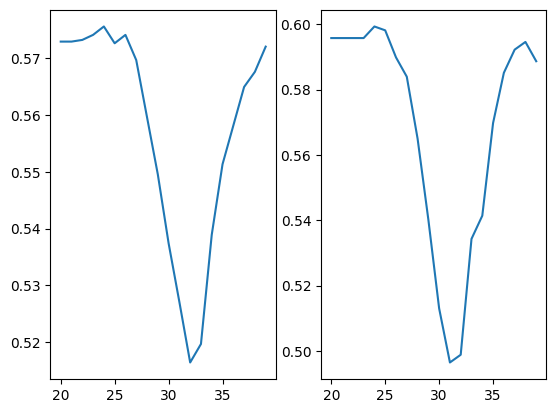

In [17]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2)
ages =list(range(20,40))
ax[0].plot(ages, train_scores)
ax[1].plot(ages, test_scores)

# WHAT??

How is this possible. This is the exact opposite of conventional knowledge. That distance from prime age is the WORST age predictor and that in general just being younger is better...

OK how about a nonlinear intuitive age score

In [18]:
age_score_dict = {
    18:6,
    19:6,
    20:6,
    21:7,
    22:7,
    23:7,
    24:7,
    25:8,
    26:8,
    27:8,
    28:8,
    29:8,
    30:8,
    31:8,
    32:8,
    33:8,
    34:7,
    35:7,
    36:7,
    37:6,
    38:6,
    39:5,
    40:4,
    41:3,
    42:3,
    43:3,
    44:2,
    45:2,
    46:2,
    47:1,
    48:1,
    49:1,
    50:1,
    51:1
}

def age_score(age):
    return age_score_dict[age]

age_score_vect = np.vectorize(age_score)

In [19]:
ufc_fights_reported_derived_doubled['age']

6670     28.024641
6671     31.854894
6672     27.460643
6673     22.680356
6674     27.915127
           ...    
16529    29.264887
16530    32.744695
16531    32.229979
16532    29.744011
16533    25.514031
Name: age, Length: 9864, dtype: float64

In [20]:
# add age score column

age_stat_name = f'age_scorex'
# drop rows with nan in age col
ufc_fights_reported_derived_doubled = ufc_fights_reported_derived_doubled.dropna(axis=0, how='any')
age_score = age_score_vect(ufc_fights_reported_derived_doubled['age'].astype(int))
ufc_fights_reported_derived_doubled[age_stat_name] = age_score

In [21]:
ufc_fights_predictive_flattened_diffs = dh.make_ufc_fights_predictive_flattened_diffs(ufc_fights_reported_derived_doubled)
ufc_fights_predictive_flattened_diffs = dh.clean_ufc_fights_for_winner_prediction(ufc_fights_predictive_flattened_diffs)

In [22]:
all_features = [f for f in ufc_fights_predictive_flattened_diffs.columns if not ('score_diff' in f or 'loss_diff' in f)]

In [23]:
# drop the 'fighter_result' column and opponent_result column as it is not needed for the model and also fighter and opponent columns
X = ufc_fights_predictive_flattened_diffs[all_features].drop(columns=['fighter', 'opponent', 'method', 'division'])
# KEEP result in X as this is what model_score is expecting for better or for worse
y = X['result']

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91)

In [25]:
model_test_score(X_train, X_test, ["age_scorex_diff"], _max_iter = 20000, scaled=True)

Training set size: (3409, 322) accuracy: 0.5379876796714579
Test set size: (853, 322) accuracy: 0.5404454865181711
Test set neg log loss: -0.6861651685226478. Average probability to observe data given model: 0.5035032215547954


(0.5379876796714579, 0.5404454865181711)

In [28]:
# remove all rows with age = nan
ufc_fights_predictive_flattened = dh.make_ufc_fights_predictive_flattened(ufc_fights_reported_derived_doubled)
ufc_fights_predictive_flattened = ufc_fights_predictive_flattened.dropna(subset=['fighter_age', 'opponent_age'])

Text(0, 0.5, 'Opponent Age')

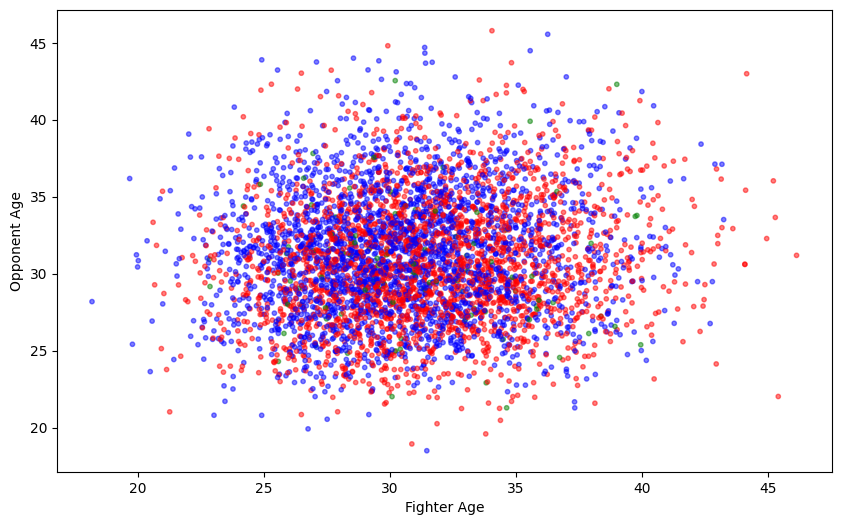

In [33]:
# scatter the ages from the doubled derived data and color by win
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
fighter_age = ufc_fights_predictive_flattened['fighter_age']
opponent_age = ufc_fights_predictive_flattened['opponent_age']
result = ufc_fights_predictive_flattened['result']
result_color = result.map({'W': 'blue', 'L': 'red', 'D': 'green'})
plt.scatter(fighter_age, opponent_age, color=result_color, s=10, alpha=0.5)
plt.xlabel('Fighter Age')
plt.ylabel('Opponent Age')


Text(0.5, 1.0, 'Age Difference vs Result')

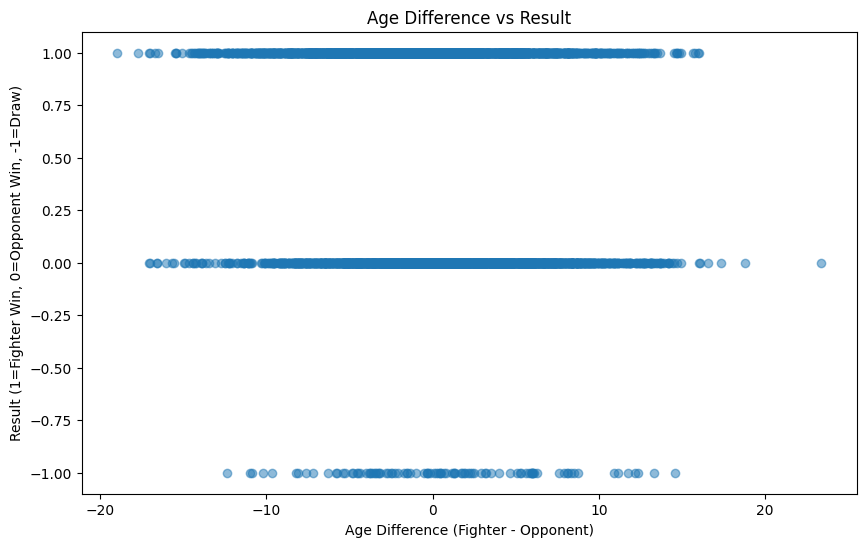

In [35]:
# plot age diff by win/loss as 1/0
plt.figure(figsize=(10, 6))
age_diff = ufc_fights_predictive_flattened['fighter_age'] - ufc_fights_predictive_flattened['opponent_age']
result_binary = ufc_fights_predictive_flattened['result'].map({'W': 1, 'L': 0, 'D': -1})
plt.scatter(age_diff, result_binary, alpha=0.5)
plt.xlabel('Age Difference (Fighter - Opponent)')
plt.ylabel('Result (1=Fighter Win, 0=Opponent Win, -1=Draw)')
plt.title('Age Difference vs Result')


In [ ]:
# TODO split this up by division and plot each division separately